# Project Gantt Chart (Nov 3 — Dec 8)

This notebook creates a project Gantt chart covering the main activities for the project: data loading, preprocessing, PCA/EDA, model experiments, evaluation, buffer time, presentation preparation, and final submission.

The chart shows weekly breakdowns, parallel activities, dependencies, key deliverables, and buffer time. You can edit the `tasks` table in the first code cell to adjust dates or add/remove tasks.

In [23]:
# Build the task table
import pandas as pd
from datetime import datetime

# Define tasks: name, start, end, lane (for grouping), depends (list), milestone flag, color hint
tasks = [
    ('Project kickoff & planning', '2025-11-03', '2025-11-04', 'Planning', [], True, '#4B8BBE'),
    ('Data acquisition', '2025-11-03', '2025-11-07', 'Data', ['Project kickoff & planning'], False, '#306998'),
    ('Data preprocessing', '2025-11-06', '2025-11-13', 'Data', ['Data acquisition'], False, '#FFD43B'),
    ('Exploratory analysis & PCA', '2025-11-10', '2025-11-17', 'EDA', ['Data preprocessing'], False, '#646464'),
    ('Modeling: Method A prototyping (RandomForest)', '2025-11-14', '2025-11-21', 'Modeling', ['Exploratory analysis & PCA'], False, '#2E8B57'),
    ('Modeling: Method B prototyping (SVM)', '2025-11-14', '2025-11-21', 'Modeling', ['Exploratory analysis & PCA'], False, '#8B4513'),
    ('Modeling: Method C prototyping (NN/CNN)', '2025-11-17', '2025-11-28', 'Modeling', ['Exploratory analysis & PCA'], False, '#6A5ACD'),
    ('Hyperparameter tuning & CV', '2025-11-22', '2025-11-30', 'Modeling', ['Modeling: Method A prototyping (RandomForest)', 'Modeling: Method B prototyping (SVM)', 'Modeling: Method C prototyping (NN/CNN)'], False, '#D2691E'),
    ('Evaluation & model comparison', '2025-11-29', '2025-12-04', 'Evaluation', ['Hyperparameter tuning & CV'], False, '#20B2AA'),
    ('Buffer / unexpected issues', '2025-11-25', '2025-12-01', 'Buffer', [], False, '#B22222'),
    ('Final presentation prep', '2025-12-02', '2025-12-04', 'Deliverable', ['Evaluation & model comparison'], True, '#FF69B4'),
    ('Final report & code submission', '2025-12-08', '2025-12-08', 'Deliverable', ['Final presentation prep', 'Evaluation & model comparison'], True, '#000000'),
    ('Documentation & README polish', '2025-12-01', '2025-12-07', 'Deliverable', ['Evaluation & model comparison'], False, '#4682B4'),
]

df = pd.DataFrame(tasks, columns=['task','start','end','lane','depends','milestone','color'])
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
df['duration'] = (df['end'] - df['start']).dt.days + 1

# show table
df

,task,start,end,lane,depends,milestone,color,duration
0,Project kickoff & planning,2025-11-03,2025-11-04,Planning,[],True,#4B8BBE,2
1,Data acquisition,2025-11-03,2025-11-07,Data,[Project kickoff & planning],False,#306998,5
2,Data preprocessing,2025-11-06,2025-11-13,Data,[Data acquisition],False,#FFD43B,8
3,Exploratory analysis & PCA,2025-11-10,2025-11-17,EDA,[Data preprocessing],False,#646464,8
4,Modeling: Method A prototyping (RandomForest),2025-11-14,2025-11-21,Modeling,[Exploratory analysis & PCA],False,#2E8B57,8
5,Modeling: Method B prototyping (SVM),2025-11-14,2025-11-21,Modeling,[Exploratory analysis & PCA],False,#8B4513,8
6,Modeling: Method C prototyping (NN/CNN),2025-11-17,2025-11-28,Modeling,[Exploratory analysis & PCA],False,#6A5ACD,12
7,Hyperparameter tuning & CV,2025-11-22,2025-11-30,Modeling,[Modeling: Method A prototyping (RandomForest)...,False,#D2691E,9
8,Evaluation & model comparison,2025-11-29,2025-12-04,Evaluation,[Hyperparameter tuning & CV],False,#20B2AA,6
9,Buffer / unexpected issues,2025-11-25,2025-12-01,Buffer,[],False,#B22222,7


Saved Gantt overview to c:\Users\Mikey\Documents\GitHub\cmse492_project\Reports\gantt_overview.png


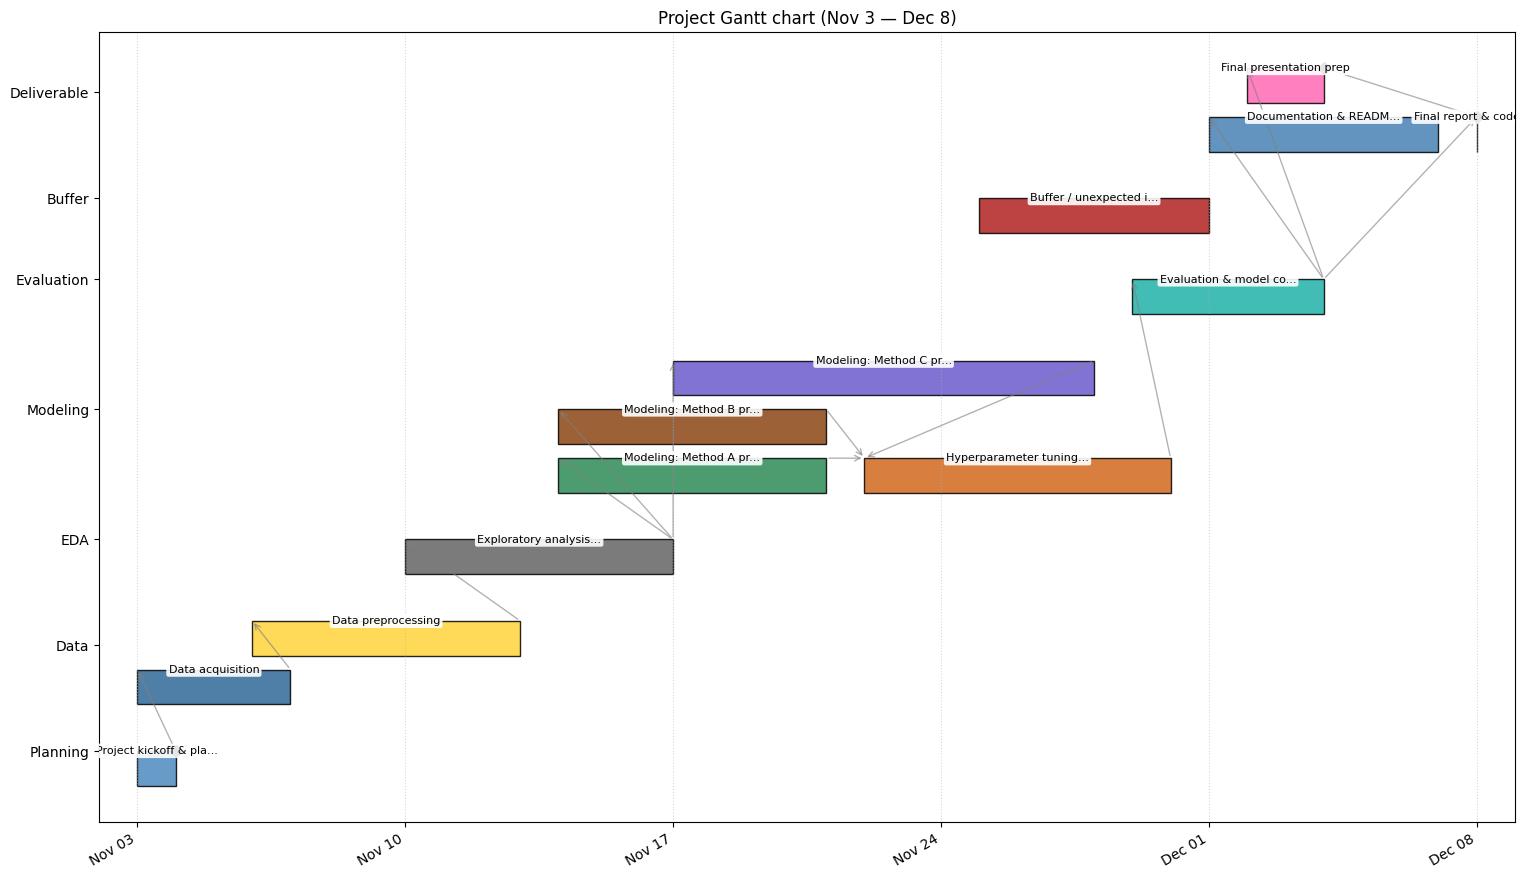

In [27]:
# Plot a Gantt chart using matplotlib (stack overlapping tasks into slots per lane)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
from collections import defaultdict
import textwrap
import sys

# discover repository root (same approach used in other notebooks)
cwd = Path.cwd()
repo_root = None
for p in [cwd] + list(cwd.parents):
    if (p / 'src').exists() or (p / '.git').exists():
        repo_root = p
        break
if repo_root is None:
    repo_root = cwd
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# ensure output saved under repo Reports folder (fixes Reports/Reports duplication)
fig_path = repo_root / 'Reports' / 'gantt_overview.png'
fig_path.parent.mkdir(parents=True, exist_ok=True)

# Parameters for slotting
slot_height = 0.45        # height of each mini-row
slot_gap = 0.18           # vertical gap between slots inside same lane
lane_gap = 0.6            # extra space between lanes
label_short_len = 24      # characters to show inside bars
label_wrap_width = 30     # if short label still long, wrap it

# Build per-lane task lists
lane_tasks = defaultdict(list)
for idx, row in df.sort_values(['lane','start']).iterrows():
    lane_tasks[row['lane']].append((idx, row))

# Greedy slot assignment per lane: assign lowest slot index with no overlap
slot_assignments = {}   # idx -> slot_index
max_slots_per_lane = {}
for lane, tasks in lane_tasks.items():
    slots_ends = []
    for idx, row in tasks:
        s = mdates.date2num(row['start'].to_pydatetime())
        e = mdates.date2num(row['end'].to_pydatetime())
        placed = False
        for slot_i, last_end in enumerate(slots_ends):
            if s > last_end + 1e-6:
                slots_ends[slot_i] = e
                slot_assignments[idx] = slot_i
                placed = True
                break
        if not placed:
            slot_assignments[idx] = len(slots_ends)
            slots_ends.append(e)
    max_slots_per_lane[lane] = len(slots_ends)

# compute lane base y offsets
lane_order = list(df['lane'].unique())
lane_base = {}
cum_y = 0.0
for lane in lane_order:
    lane_base[lane] = cum_y
    slots = max_slots_per_lane.get(lane, 1)
    cum_y += slots*slot_height + max(0, slots-1)*slot_gap + lane_gap

# create figure sized by cum_y; widen figure to reduce label clipping
fig_height = max(6, cum_y * 0.9)
fig, ax = plt.subplots(figsize=(16, fig_height))

# helper to produce short unique labels
def make_short_label(name, maxlen=label_short_len, existing=None):
    s = name if len(name) <= maxlen else name[:maxlen-3].rstrip() + '...'
    # ensure uniqueness by appending index if duplicate
    if existing is None:
        return s
    base = s
    i = 1
    while s in existing:
        suffix = f' ({i})'
        # keep within maxlen if possible
        trim = maxlen - len(suffix)
        short_base = base[:trim-3].rstrip() + '...' if len(base) > trim else base
        s = short_base + suffix
        i += 1
    return s

# build mapping short->full and assign to each row index
short_map = {}
idx_to_short = {}
for idx, row in df.iterrows():
    short = make_short_label(row['task'], existing=set(short_map.keys()))
    short_map[short] = row['task']
    idx_to_short[idx] = short

# plot tasks with short labels centered in each bar
for idx, row in df.iterrows():
    start_num = mdates.date2num(row['start'].to_pydatetime())
    end_num = mdates.date2num(row['end'].to_pydatetime())
    slot_i = slot_assignments.get(idx, 0)
    base = lane_base[row['lane']]
    y = base + slot_i*(slot_height + slot_gap)
    ax.barh(y, end_num - start_num, left=start_num, height=slot_height,
            color=row['color'], edgecolor='k', alpha=0.85)
    # compute midpoint for centered short label
    mid_x = start_num + 0.5 * (end_num - start_num)
    short_label = idx_to_short[idx]
    wrapped = textwrap.fill(short_label, width=label_wrap_width)
    text_y = y + slot_height/2
    # draw a small white box behind text to improve readability on colored bars
    ax.text(mid_x, text_y, wrapped, va='center', ha='center', fontsize=8, color='black',
            multialignment='center', clip_on=True,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.9),
            zorder=10)
    if row['milestone']:
        ax.plot(end_num, y + slot_height/2, marker='D', color='black')

# prepare mapping of task end positions for arrows (use original full task name keys)
task_end_y = {}
for idx, row in df.iterrows():
    slot_i = slot_assignments.get(idx, 0)
    base = lane_base[row['lane']]
    y = base + slot_i*(slot_height + slot_gap) + slot_height/2
    task_end_y[row['task']] = (mdates.date2num(row['end'].to_pydatetime()), y)

# draw dependency arrows
for idx, row in df.iterrows():
    dest_start = mdates.date2num(row['start'].to_pydatetime())
    dest_y = lane_base[row['lane']] + slot_assignments.get(idx, 0)*(slot_height+slot_gap) + slot_height/2
    for dep in row['depends']:
        if dep in task_end_y:
            dep_end_num, dep_y = task_end_y[dep]
            ax.annotate('', xy=(dest_start, dest_y), xytext=(dep_end_num, dep_y),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=1, alpha=0.6))

# x-axis formatting
ax.xaxis_date()
start_xlim = mdates.date2num(pd.Timestamp('2025-11-03').to_pydatetime())
end_xlim = mdates.date2num(pd.Timestamp('2025-12-08').to_pydatetime())
ax.set_xlim(start_xlim - 1, end_xlim + 1)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# y-ticks centered per lane
yticks = []
ytick_labels = []
for lane in lane_order:
    slots = max_slots_per_lane.get(lane, 1)
    base = lane_base[lane]
    total_height = slots*slot_height + (slots-1)*slot_gap
    center = base + total_height/2
    yticks.append(center)
    ytick_labels.append(lane)

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_title('Project Gantt chart (Nov 3 — Dec 8)')
ax.grid(axis='x', linestyle=':', alpha=0.5)
plt.tight_layout()
# expand right margin slightly to avoid clipping long labels
fig.subplots_adjust(right=0.95)
fig.savefig(fig_path, dpi=200)
print('Saved Gantt overview to', fig_path)
plt.show()


## How to customize
- Edit the `tasks` list at the top of the notebook: change start/end dates, add/remove tasks, or change `depends`. Dates must be in YYYY-MM-DD format.
- The `lane` column groups tasks vertically (e.g., Data, Modeling, Deliverable, Buffer).
- Milestones are marked with a diamond marker.

## Exporting
The chart is saved to `Reports/gantt_overview.png`. You can also export the `df` DataFrame to CSV for sharing.

In [25]:
# Caption: map of short labels to full task names
from IPython.display import Markdown, display

md_lines = ['### Task legend — short label → full task name', '']
for short, full in short_map.items():
    md_lines.append(f'- **{short}**: {full}')

display(Markdown('\n'.join(md_lines)))


### Task legend — short label → full task name

- **Project kickoff & planning**: Project kickoff & planning
- **Data acquisition**: Data acquisition
- **Data preprocessing**: Data preprocessing
- **Exploratory analysis & PCA**: Exploratory analysis & PCA
- **Modeling: Method A prototyping (RandomForest)**: Modeling: Method A prototyping (RandomForest)
- **Modeling: Method B prototyping (SVM)**: Modeling: Method B prototyping (SVM)
- **Modeling: Method C prototyping (NN/CNN)**: Modeling: Method C prototyping (NN/CNN)
- **Hyperparameter tuning & CV**: Hyperparameter tuning & CV
- **Evaluation & model comparison**: Evaluation & model comparison
- **Buffer / unexpected issues**: Buffer / unexpected issues
- **Final presentation prep**: Final presentation prep
- **Final report & code submission**: Final report & code submission
- **Documentation & README polish**: Documentation & README polish